Project 1 

Zack Owens

6/9/2023

In [1]:
using Base.Threads

# 1

NOTE need to run sinx.(x,1000) instead of for loops

In [12]:
function sinx_seq(x, n = 5; degree = true)
    if degree
        xRad = deg2rad(x % 360)
    else
        xRad = x
    end
    value = xRad
    numer = xRad^3.0
    denom = 6.0
    sign = -1.0
    for i in 1:n
        value += sign*numer/denom
        numer *= xRad^2.0
        denom *= (2.0 * i + 2.0) * (2.0 * i +3.0)
        sign *= -1.0
    end
    return value
end

sinx_seq (generic function with 2 methods)

In [13]:
function sinx_seq_simd(x, n = 5; degree = true)
    if degree
        xRad = deg2rad(x % 360)
    else
        xRad = x
    end
    value = xRad
    numer = xRad^3.0
    denom = 6.0
    sign = -1.0
    @simd for i in 1:n
        value += sign*numer/denom
        numer *= xRad^2.0
        denom *= (2.0 * i + 2.0) * (2.0 * i +3.0)
        sign *= -1.0
    end
    return value
end

sinx_seq_simd (generic function with 2 methods)

In [14]:
# seq     
@time for i in 0:0.000_01:90
    sinx_seq(i,1000)
end

 30.922111 seconds


In [15]:
# simd
@time for i in 0:0.000_01:90
    sinx_seq_simd(i,1000)
end

 30.832594 seconds


In [21]:
# threaded    
@time @threads for i in 0:0.000_01:90
    sinx_seq(i,1000)
end

  4.587285 seconds (41.64 k allocations: 2.820 MiB, 0.25% gc time, 7.12% compilation time)


In [22]:
@time @threads for i in 0:0.000_01:90
    sinx_seq_simd(i,1000)
end

  4.338472 seconds (22.06 k allocations: 1.536 MiB, 5.36% compilation time)


# Results

|Run Type|Time|
|--|--|
|Sequential| 30.922111 seconds|
|SIMD| 30.832594 seconds|
|Multi-Theaded|4.587285 seconds|
|SIMD and Multi-Threaded| 4.338472 seconds |

Overall, the largest increase is multithreading. This took the runtimes from 30 seconds to less than 5 seconds. The SIMD always increased the performance but not by nearly as much as multi-threading increased the performance. Without using either method of parallel computing performed the worst.

|Run Type|Speedup|
|--|--|
|SIMD| 0.0029033236710475933358056088307|
|Multi-Theaded|6.7408305784358286001414780202233|
|SIMD and Multi-Threaded| 7.1274197459382012837699540298981 |

Overall, the speedup of SIMD is very minimal on its own being under 1%. The increase of multithreading is 6.7 times faster than sequential computing. This is a major speedup with the use of 12 threads. The SIMD and multi-threaded increase is best speedup of all with over 7 times speedup using both 12 threads and the single instruction multiple data operators in my Ryzen 6 CPU.

# 2.1

In [10]:
using BenchmarkTools;
using Base.Threads;
using Plots;

function setMandelbrotPixel(c, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
        abs2(z)> 4.0 && return (i-1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end


function MandelbrotSet_threaded(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic
end


function MandelbrotSet(niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel(x+y*im, niter)
        end
    end
    return pic
end
   
   

MandelbrotSet (generic function with 8 methods)

In [15]:
@btime mandel = MandelbrotSet();

  34.748 ms (2 allocations: 468.86 KiB)


600×800 Matrix{UInt8}:
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00  …  0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
    ⋮                             ⋮  ⋱           ⋮                    
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00  0x00  0x00  0x00  0x00  0x00     0x01  0x01  0x01  0x01  0x01  0x01
 0x00 

In [6]:
@btime mandel_threaded = MandelbrotSet_threaded();

  8.407 ms (70 allocations: 477.20 KiB)


In [31]:
heatmap(1:size(mandel,2),1:size(mandel,1), mandel, color = :thermal)

UndefVarError: UndefVarError: `mandel` not defined

# 2.2

In [20]:
function MandelbrotSet_threaded_modified(array,niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    @threads for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_t(x+y*im, array, niter)
        end
    end
    return pic
end

function setMandelbrotPixel_t(c, array, niter=255)
    1 ≤ niter ≤ 255 ? niter : 255
    z = zero(typeof(c))
    z = z*z + c
    for i in 1:niter
        array[threadid()] += 1
        abs2(z)> 4.0 && return (i-1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end



setMandelbrotPixel_t (generic function with 2 methods)

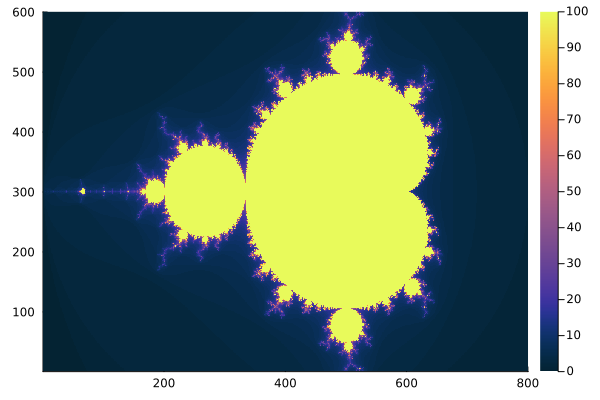

In [21]:
array1 = Int128[0,0,0,0,0,0,0,0,0,0,0,0]
mandel1 = MandelbrotSet_threaded_modified(array1)
heatmap(1:size(mandel1,2),1:size(mandel1,1), mandel1, color = :thermal)

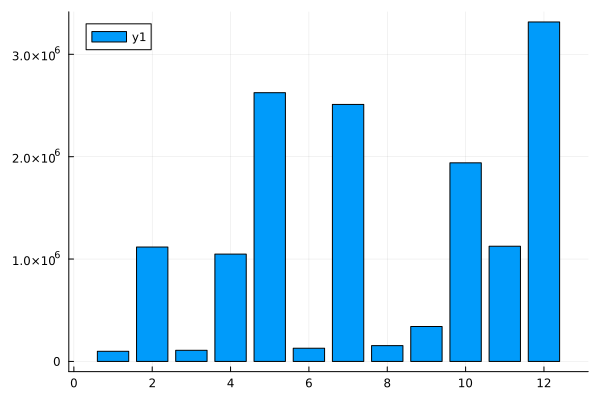

In [23]:

bar(array1)

# 2.3

In [30]:
function MandelbrotSet_threaded_modified_fixed(array,niter=100, width=800, height=600,
    x_start=-2.0, y_start=-1.0, x_fin=1.0, y_fin=1.0)
    pic = Matrix{UInt8}(undef, height, width)
   
    dx = (x_fin-x_start)/(width-1);
    dy = (y_fin-y_start)/(height-1);
   
    # Compute pic column by column
    @spawn for j in 1:width
        x = x_start+(j-1)*dx
        for i in 1:height
            y = y_fin-(i-1)*dy
            @inbounds pic[i,j] = setMandelbrotPixel_t(x+y*im, array, niter)
        end
    end
    return pic
end


MandelbrotSet_threaded_modified_fixed (generic function with 8 methods)

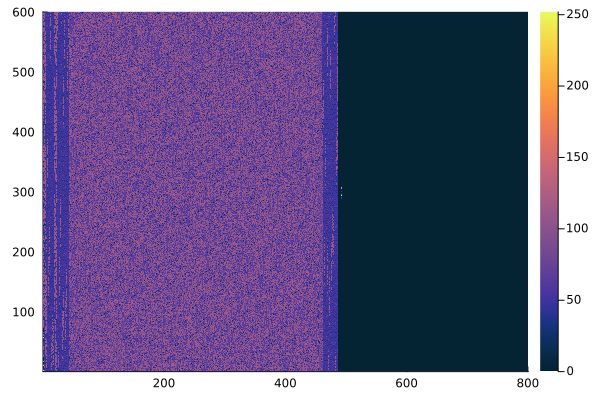

In [32]:
using ColorSchemes
array2 = Int128[0,0,0,0,0,0,0,0,0,0,0,0]
mandel2 = MandelbrotSet_threaded_modified_fixed(array2)
heatmap(1:size(mandel2,2),1:size(mandel2,1), mandel2, color = :thermal)

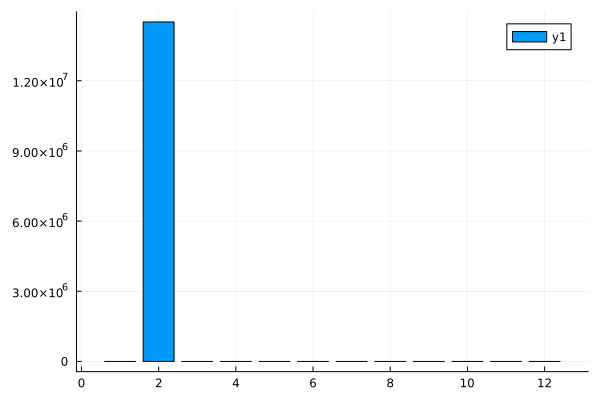

In [33]:
using Plots
bar(array2)

In [ ]:
array3 = Int128[0,0,0,0,0,0,0,0,0,0,0,0]
@spawn for i in 1:1_000_000_000:

# 3

In [15]:
using Random
using BenchmarkTools;
using Base.Threads;
random_numbers = rand(Int32,10_000_000)

10000000-element Vector{Int32}:
   506808894
  -114349374
 -1788297882
  1317997519
  1605105048
  1202776252
  -303815962
 -1474691964
  1981861417
  1911830575
           ⋮
   414635924
   499099201
 -1861623761
 -1995647266
  1094504192
   668462555
 -1676907054
   148379697
  2113490505

In [2]:
function sum_seq(x)
    s = 0
    for i in x
        s +=i
    end
    return s
end

@btime sum_seq(random_numbers)

  2.507 ms (1 allocation: 16 bytes)


-654887236593

In [27]:
@btime Base.sum(random_numbers)

  2.578 ms (1 allocation: 16 bytes)


-6728602792201

In [56]:
# TO DO PARTIAL SUM
function partialSums(x)
    if Threads.nthreads() == 1
        print("only one thread using 1 thread")
        return sum(x)
    end
    t=Threads.nthreads()
    split = Int64(length(x) // t)
    partial_sums = [0 for x in 1:t]
    println(split,partial_sums)
    @threads for i in 1:t
        if(i==t)
            partial_sums[i] = sum(x[(i-1)*split+1:length(x)])
            println((i-1)*split,'x',length(x))
            continue
        end
        if(i==1)
            partial_sums[i] = sum(x[1:split*i])
            println(0,'i',split*i)
            continue
        end
        partial_sums[i] = sum(x[(i-1)*split+1:split*i])
        println((i-1)*split,' ',split*i)
    end
    println(partial_sums)
    return sum(partial_sums) 
end

partialSums(random_numbers)

1250000[0, 0, 0, 0, 0, 0, 0, 0]


8750000x10000000
0i1250000
7500000 8750000
6250000 7500000
1250000 2500000
2500000 3750000
5000000 6250000
3750000 5000000
[875566761244, -1220366032785, -907389153451, 60723507497, -335910411594, -1290936067182, -3255764176455, -654527219475]


-6728602792201